**Super-Resolution Tutorial** By ct538

This tutorial is based off the work I did in my dissertation. It is a small tutorial that goes through constructing Meta-SRGAN and running it through several applications such as photography, medical image enhancement, and text reconstruction. Note that this is but just a small subset of the work I did for my dissertation.

Super-Resolution is generally divided into two types: Single-Image Super-Resolution and Multiple-Images Super-Resolution. The former seeks to upscale an image based on a single image, whilst the latter incorporates information from several sources to upscale an image. Multiple-Images Super-Resolution takes more effort and requires more data, and hence will not be covered in this tutorial. We will focus mainly on Single-Image Super-Resolution.

This tutorial is self-contained; example images and pre-trained models are provided in the folder in the same directory as this notebook.

This tutorial is meant to be lightweight. You will not be doing any training of neural networks so you don't need a GPU.


**Prerequisites**

You will need:


*   PyTorch (with or without CUDA it's fine)
*   Matplotlib
*   Numpy
*   Pandas
*   tqdm
*   PIL

So install them if you haven't or run this on Google Colab.



This tutorial is structured as follows:
  1. We will first look at Meta-SRGAN, which uses a weight prediction network to predict weights for different scales. This is based off Hu's Meta-Upscale Module ([paper here](https://arxiv.org/pdf/1903.00875.pdf)) and SRGAN ([paper here](https://arxiv.org/pdf/1609.04802.pdf)). SRGAN manages to achieve visually realistic images compared to other other networks.

  2. We will then explore several applications of Meta-SRGAN, from photography, to medical imaging, to text enhancement.

First, we extract the zip file that contains our pre-trained models and some example images.

In [0]:
import os
import zipfile
with zipfile.ZipFile('metasrgan_tutorial_resources.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

BadZipFile: ignored

There should be 5 files, 3 png files and 2 pth files. They should be:


1.   metasrgan_tutorial.pth - Our pretrained model.
2.   metasrgan_tutorial_brats.pth - Our pretrained model trained on the BraTS brain MRI dataset.
3.   photography_example.png - Our example image for the photography application.
4.   brats_example.png - Our example image for the medical imaging application.
5.   text_example.png - Our example image for the text enhancement application.



Then, we import all our libraries.

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import imageio
import matplotlib.pyplot as plt
import math
import numpy as np
import random
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # This sets us up to use GPU if possible. If not,  we will revert back to using CPU.

We want to size any improperly sized images to a defined size so that it's easier to work with them.

In [0]:
# The test transform function extracts out the center crop of the image. The idea is that this would make testing consistent, as each test would be run on the same images. Consistent tests would make performance comparisons between models fairer.
def test_transform(crop_size):
  """Transform function for test data. Basically just crops the center of the test data.
  :param crop_size: Size of crop that we wish to do."""
  return transforms.CenterCrop(crop_size)

**PART I: Meta-SRGAN**

Let's explore Meta-SRGAN and the use of a Weight Prediction Network to tackle arbitrary upscaling factors.

Meta-SRGAN is based off SRGAN ([paper here](https://arxiv.org/pdf/1609.04802.pdf)), and is effectively a Generative Adversarial Network. There are two networks being trained in a Generative Adversarial Network. There is the generator which generates an image (in this case it super-resolves an image) which is then fed into the discriminator which
discriminates between a real and a generated image (in this case it determines whether the image presented is the ground truth high-resolution, or not). This feedback from the discriminator is then used to further train the generator. Both generator and discriminator are playing a game to outbid each other. The generator tries to improve its ability to generate images that can fool the discriminator whilst the discriminator tries to improve its ability to discern real
images from generated images. This adversarial learning enables us to generate
more realistic and detailed images.

Let's build the Generator and Discriminator bottom-up.

The Generator has Residual Blocks to add the inputs to the outputs. Let's implement the Residual Block. Residual Blocks add inputs to the outputs and increments the input with the output. This therefore uses higher level information to improve the input.





In [0]:
# The Generator
class ResidualBlockSRGAN(nn.Module):
    def __init__(self, channels):
      """
      Builds a Residual Block. A ResBlock contains a Conv2d, BatchNorm2d, PReLU activation, 
      Conv2d, and BatchNorm2d.
      :param n_feats: Number of channels in each convolution.
      :param kernel_size: Window size in each convolution.
      :param res_scale: Amount to multiply the data with in the multiply block.
      """
      super(ResidualBlockSRGAN, self).__init__()
      self.channels = channels
      self.build_block()

    def build_block(self):
      """
      Actually builds the Residual Block. A ResBlock contains a Conv2d, BatchNorm2d, PReLU activation, 
      Conv2d, and BatchNorm2d.
      """
      self.block1 = nn.Sequential(
          nn.Conv2d(self.channels, self.channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(self.channels),
          nn.PReLU(),
          nn.Conv2d(self.channels, self.channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(self.channels)
      )

    def forward(self, x):
      """
      Forward propagates through the block.
      :param x: Input features.
      :return: Output of the ResBlock, of size (batch_size, n_feats, input_H, input_W)
      """
      residual = self.block1(x)
      return x + residual

Now let's combine these Residual Blocks together.

In [0]:
# The Generator
class Generator(nn.Module):
    def __init__(self,scale_factor,in_channels = 1, out_channels = 1):
      """
      Builds the Generator network.
      :param scale_factor: Scale factor which we are using.
      :param in_channels: Number of input channels. Must be same as number of output channels. 
      If RGB images, use 3, if grayscale, use 1.
      :param out_channels: Number of output channels. If RGB images, use 3, if grayscale, use 1.
      """
      super(Generator,self).__init__()
      self.scale_factor = scale_factor
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.build_generator()
    
    def build_generator(self):
      """
      Actually builds the Generator network. It includes 8 blocks. The first block is 
      just a convolution and PReLU activation. Blocks 2 to 6 are Residual Blocks.
      Block 7 is a Convolution. Block 8 is the Meta-Upscale Module.
      """
      self.block1 = nn.Sequential(
        nn.Conv2d(self.in_channels,64,kernel_size=9,padding=4),
        nn.PReLU()
      )
      self.block2 = ResidualBlockSRGAN(64)
      self.block3 = ResidualBlockSRGAN(64)
      self.block4 = ResidualBlockSRGAN(64)
      self.block5 = ResidualBlockSRGAN(64)
      self.block6 = ResidualBlockSRGAN(64)
      self.block7 = nn.Sequential(
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64)
      )
      self.MetaUpscaleModule = MetaUpscaleModule(64,self.out_channels,self.scale_factor)
    
    def update_scale(self, new_scale):
      """
      Updates the scale used by the Meta-Upscale Module. Allows for on-demand changing of scaling factor.
      :param new_scale: new scale.
      """
      self.MetaUpscaleModule.update_scale(new_scale)

    def forward(self, x, v):
      """
      Forward propagates through the network.
      :param x: input low-resolution image.
      :param v: Input matrix to the Weight Prediction Network.
      :return: Super-resolved image, of size (batch_size, out_channels, upscale_factor*input_H, upscale_factor*input_W)
      """
      block1 = self.block1(x)
      block2 = self.block2(block1)
      block3 = self.block3(block2)
      block4 = self.block4(block3)
      block5 = self.block5(block4)
      block6 = self.block6(block5)
      block7 = self.block7(block6)
      block8 = self.MetaUpscaleModule(block1 + block7, v)

      return block8

Notice that block8 is Hu's Meta Upscale Module. This is essentially a separate weight prediction network that predicts weights for each scale. Note also how we are able to update the scale using the update_scale method. This provides a nifty way for us to change the scale of the Meta-Upscale Module on-the-fly.

Let's implement that now.

In [0]:
# The Generator
class MetaUpscaleModule(nn.Module):
  def __init__(self, num_channels_features, out_channels, upscale_factor, kernel_size = 3):
    super(MetaUpscaleModule,self).__init__()
    self.num_channels_features = num_channels_features
    self.out_channels = out_channels
    self.upscale_factor = upscale_factor
    self.kernel_size = kernel_size
    self.build_module()
  
  def build_module(self):
    self.weight_prediction_network = WeightPredictionNetwork(
                                      num_channels_features = self.num_channels_features,
                                      out_channels = self.out_channels,
                                      kernel_size = self.kernel_size)
    
  def update_scale(self,new_scale):
    self.upscale_factor = new_scale

  def add_dimensions(self,x):
    scale_int = math.ceil(self.upscale_factor)
    N,C,H,W = x.size()
    x = x.view(N,C,H,1,W,1)

    x = torch.cat([x]*scale_int,3)
    x = torch.cat([x]*scale_int,5)
    x = x.contiguous().permute(0,3,5,1,2,4) # idea is to go from (B,C,inH,scale,inW,scale) to (B,scale,scale,C,inH,inW) to make it easier to view.

    return x.contiguous().view(-1, C, H, W)

  def forward(self, F_LR, v):
    N, C, inH, inW = F_LR.shape
    # F_LR is the dense features extract through the Feature Extractor
    # vij = (i/r - floor(i/r) , j/r - floor(j/r), 1/r)
    W = self.weight_prediction_network(v)
    scale_int = int(math.ceil(self.upscale_factor))
    F_LR_added_dimensions = self.add_dimensions(F_LR)
    t = nn.functional.unfold(F_LR_added_dimensions,kernel_size = 3,padding = 1)
    F_LR_final = t.contiguous().view(N, scale_int * scale_int , -1, inH * inW, 1)
    F_LR_final = F_LR_final.contiguous().permute(0,1,3,4,2) # idea is to go from (B,scale*scale,k*k*C,inH*inW,1) to (B,scale*scale,inH*inW,1,k*k*C)
    W = W.contiguous().view(inH, scale_int, inW, scale_int, -1, self.out_channels)
    W = W.contiguous().permute(1,3,0,2,4,5) # idea is to go from (inH,scale,inW,scale,k*k*C,outC) to (scale,scale,inH,inW,k*k*C,outC)
    W = W.contiguous().view(scale_int * scale_int, inH * inW, -1, self.out_channels)

    out = torch.matmul(F_LR_final,W) # This is where the magic happens.

    out = out.contiguous().permute(0,1,4,2,3) # idea is to go from (B,scale*scale,inH*inW,1,outC) to (B,scale*scale,outC,inH*inW,1)
    out = out.contiguous().view(N, scale_int, scale_int, self.out_channels, inH, inW)
    out = out.contiguous().permute(0,3,4,1,5,2) # idea is to go from (B,scale,scale,outC,inH,inW) to (B,outC,inH,scale,inW,scale)
    out = out.contiguous().view(N,self.out_channels,scale_int * inH, scale_int * inW)
    
    mask = create_mask(inH, inW, self.upscale_factor) # Note the use of a mask here. We will talk about this later.
    out = torch.masked_select(out.cpu(),mask).to(device)
    out = out.contiguous().view(N,self.out_channels,int(self.upscale_factor*inH),int(self.upscale_factor*inW))
    del mask
    return out

The idea of the Meta-Upscale Module is this: 

First we increase the size of the image, then we multiply it with the weights. The various permutes and views simply sizes the weights and input features such that their dimensions will match for the matrix multiplication to work.

Let's implement the Weight Prediction Network now.

In [0]:
class WeightPredictionNetwork(nn.Module):
  def __init__(self,num_channels_features,out_channels,kernel_size = 3):
    super(WeightPredictionNetwork,self).__init__()
    self.num_channels_features = num_channels_features
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.build_network()
  
  def build_network(self):
    self.wpn = nn.Sequential(
        nn.Linear(3,256),
        nn.ReLU(),
        nn.Linear(256,self.num_channels_features * self.out_channels * self.kernel_size * self.kernel_size)  
    )
  def forward(self,x):
    out = self.wpn(x)
    return out

The input to the Weight Prediction Network must specify the dimensions of the super-resolved image, in order to create a matrix of weights of the appropriate size. That is, the input matrix must be of dimensions (outW * outH, 3).

The values within the input matrix, according to Hu, should be the relative position to the nearest influencing pixel. Basically Hu thinks that the input matrix is a dictionary that maps every super-resolved pixel, to its closest influencing pixel in the low-resolution image. But I have tried various initialisations for the input matrix and they work as well. You can implement any initialisation you want, go experiment!

I will work with Hu's suggestion. 

In the code below, v is the input matrix that will be inputted into the Weight Prediction Network.



In [0]:
def create_v(inH, inW, r):
  scale_int = int(math.ceil(r))
  oversizedH = scale_int * inH
  oversizedW = scale_int * inW
  srH = int(inH * r)
  srW = int(inW * r)

  h = torch.arange(0,srH,1).float().div(r) - torch.arange(0,srH,1).float().div(r).floor()
  sr_to_lr_map = torch.arange(0,srH,1).float().div(r).floor().int()
  result_h = torch.ones(inH,scale_int)

  current_influence = 0
  prev_lr = 0
  for sr, lr in enumerate(sr_to_lr_map):
    if lr == prev_lr:
      result_h[lr,current_influence] = h[sr]
      prev_lr = lr
      current_influence += 1
    else:
      current_influence = 0
      result_h[lr,current_influence] = h[sr]
      current_influence += 1
      prev_lr = lr

  w = torch.arange(0,srW,1).float().div(r) - torch.arange(0,srW,1).float().div(r).floor()
  sr_to_lr_map = torch.arange(0,srW,1).float().div(r).floor().int()
  result_w = torch.ones(inW,scale_int)

  current_influence = 0
  prev_lr = 0
  for sr, lr in enumerate(sr_to_lr_map):
    if lr == prev_lr:
      result_w[lr,current_influence] = h[sr]
      prev_lr = lr
      current_influence += 1
    else:
      current_influence = 0
      result_w[lr,current_influence] = h[sr]
      current_influence += 1
      prev_lr = lr

  result_h = result_h.unsqueeze(2)
  result_h = torch.cat([result_h]*oversizedW,2).view(-1,oversizedW,1) #scale_int *inW

  result_w = result_w.unsqueeze(0)
  result_w = torch.cat([result_w]*oversizedH,0).view(-1,oversizedH,1)
  result = torch.cat([result_h,result_w],2).view(-1,2) # Left join

  scale_information = torch.empty(result.shape[0], 1)
  nn.init.constant_(scale_information, 1.0/r)
  result = torch.cat([result,scale_information],1)

  return result

Notice that in the Meta-Upscale Module we use a mask. This is useful when dealing with non-integer scales, but pretty much useless when we are dealing with integer scales. The problem is that we can't have matrices of non-integer length e.g. Matrices of size (2.3 , 4.5) don't exist. The mask is a hack to help us resize the super-resolved image such that we can deal with non-integer scales.

We create this mask by counting influences. If we have an upscaling factor of r, each pixel in the low-resolution input image can influence up to r pixels in the super-resolved image. So, if we have r = 2.4, then each pixel in the low-resolution input image can influence up to 2 pixels, but every 3rd pixel can influence up to 3 pixels. So we sum the influences in the super-resolved image, and mask appropriately.

In [0]:
def create_mask(inH, inW, r):
  """
  Here we want to find out which SR pixel we should "activate". 
  The problem with non-integer upscale factors is that every pixel may not have
  the same amount of SR pixels it influences. For example, if the upscale factor were 1.5,
  then pixel 1 of the low-resolution image influences pixel 1 of the super-resolved image,
  but pixel 2 of the low-resolution image influences pixels 2 and 3 of the super-resolved image.
  This applies to both pixels going height-wise and pixels going width-wise. The crux is that
  we only want pixels that are influenced both height-wise and width-wise, and we ignore
  pixels that are only influenced once. It is a very smart algorithm for keeping the 
  size of the output super-resolved image in check.
  :param inH: Height of input low-resolution image.
  :param inW: Width of input low-resolution image.
  :param r: Upscale factor.
  :return mask: Matrix of booleans, of shape (outH, outW), that tells us which
  pixels to hide / show.
  """
  scale_int = int(math.ceil(r))
  oversizedH = scale_int * inH
  oversizedW = scale_int * inW
  srH = int(inH * r)
  srW = int(inW * r)

  h = torch.arange(0,srH,1).float().div(r) - torch.arange(0,srH,1).float().div(r).floor()
  sr_to_lr_map = torch.arange(0,srH,1).float().div(r).floor().int()
  result_h = torch.zeros(inH,scale_int)

  # current_influence tells us which new pixel we are influencing. 
  '''
  E.g. for an upscale_factor of 2, we know that a pixel in LR influences two pixels in SR. We iterate through lr,
  counting the influences.
  '''
  current_influence = 0
  prev_lr = 0
  for sr, lr in enumerate(sr_to_lr_map):
    if lr == prev_lr:
      result_h[lr,current_influence] = 1
      prev_lr = lr
      current_influence += 1
    else:
      current_influence = 0
      result_h[lr,current_influence] = 1
      current_influence += 1
      prev_lr = lr
  
  # Do the same for width.
  w = torch.arange(0,srW,1).float().div(r) - torch.arange(0,srW,1).float().div(r).floor()
  sr_to_lr_map = torch.arange(0,srW,1).float().div(r).floor().int()
  result_w = torch.zeros(inW,scale_int)

  current_influence = 0
  prev_lr = 0
  for sr, lr in enumerate(sr_to_lr_map):
    if lr == prev_lr:
      result_w[lr,current_influence] = 1
      prev_lr = lr
      current_influence += 1
    else:
      current_influence = 0
      result_w[lr,current_influence] = 1
      current_influence += 1
      prev_lr = lr

  result_h = result_h.unsqueeze(2)
  result_h = torch.cat([result_h]*oversizedW,2).view(-1,oversizedW,1) #scale_int *inW

  result_w = result_w.unsqueeze(0)
  result_w = torch.cat([result_w]*oversizedH,0).view(-1,oversizedH,1)
  result = torch.cat([result_h,result_w],2).view(-1,2) # Left join
  result = (result[:,0] + result[:,1]).eq(2).view(oversizedH,oversizedW)

  return result

The mask is just a nifty little hack to help with non-integer scales. In fact, it isn't necessary for integer scales, and the neural network can work on integer scales just fine without the mask.

Now onto the Discriminator. The discriminator discriminates images and discerns whether they are high-resolution or super-resolved images. This adversarial component helps generate visually realistic images.

In [0]:
# The Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3):
      """
      Builds the Discriminator network.
      :param in_channels: Number of input channels. If RGB images, use 3, if grayscale, use 1.
      """
      super(Discriminator,self).__init__()
      self.in_channels = in_channels
      self.build_discriminator()
    
    def build_discriminator(self):
      """
      Actually builds the Discriminator network. Includes 4 blocks. The first two blocks
      are convolutions with LeakyReLU. Block 3 is a bunch of convolutions. Block 4
      is a pooling layer.
      """
      block1 = [nn.Conv2d(self.in_channels,64,kernel_size=3,padding=1),
              nn.LeakyReLU(0.2)]
      
      block2 = [nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2)]

      block3 = []
      for i in range(3):
        prev = 64 * (1 << i)
        next = 64 * (1 << (i+1))
        block3.append(nn.Conv2d(prev, next, kernel_size=3,padding=1))
        block3.append(nn.BatchNorm2d(next))
        block3.append(nn.LeakyReLU(0.2))

        block3.append(nn.Conv2d(next,next, kernel_size=3,stride=2,padding=1))
        block3.append(nn.BatchNorm2d(next))
        block3.append(nn.LeakyReLU(0.2))


      block4 = [nn.AdaptiveAvgPool2d(1),
              nn.Conv2d(512, 1024, kernel_size=1),
              nn.LeakyReLU(0.2),
              nn.Conv2d(1024, 1, kernel_size=1)]           

      self.block1 = nn.Sequential(*block1)
      self.block2 = nn.Sequential(*block2)
      self.block3 = nn.Sequential(*block3)
      self.block4 = nn.Sequential(*block4)
    
    def forward(self,x):
      """
      Forward propagates through the network.
      :param x: input image.
      :return: binary classification of image, either fake (0) or real (1).
      """
      batch_size = x.size(0)
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.block4(x)
      return torch.sigmoid(x.reshape(batch_size))

So, we have the Generator and the Discriminator.

**PART II: Applications**

Let's now take Meta-SRGAN for a test! We are going to go through several example applications, such as photography, medical image enhancing, and text enhancement.

Notice how small Meta-SRGAN is. This makes it portable and lightweight for deployment in a whole range of scenarios.


**Photography**

We often encounter low-resolution images, such as when we try to send images via memory limited means, and when we deal with images from ye old days. Super-Resolution helps increase the resolution of these images, and make them clearer. This helps with image restoration, as it can give an idea of what the output should look like.

Take a look at the image below and see if you can recognise who it is!

(-0.5, 65.5, 65.5, -0.5)

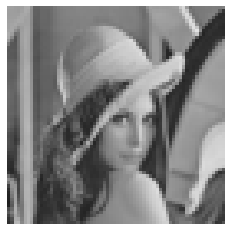

In [25]:
img = Image.open('photography_example.png').convert('YCbCr')
plt.imshow(img,cmap="gray")
plt.axis("off")

You could probably recognise her, but it's really pixelated and hard to see. Let's see if we can do anything about the pixelation and make it a tad bit higher in resolution.

We first load the image in and transform it into a PyTorch tensor.

In [26]:
img = Image.open('photography_example.png').convert('YCbCr')
h , w = img.size
img = test_transform(min(h,w))(img)
y, _,_ = img.split()
input = y
input = transforms.ToTensor()(input)
input = torch.stack([input]).to(device)
N,C,H,W = input.shape

print(input)

tensor([[[[0.6314, 0.6275, 0.6157,  ..., 0.4902, 0.4863, 0.5059],
          [0.6196, 0.6196, 0.6157,  ..., 0.4980, 0.3686, 0.2118],
          [0.6157, 0.6196, 0.6196,  ..., 0.3569, 0.1843, 0.1686],
          ...,
          [0.2627, 0.4118, 0.6431,  ..., 0.3765, 0.2549, 0.2196],
          [0.2039, 0.3176, 0.6745,  ..., 0.3020, 0.2157, 0.2118],
          [0.1804, 0.2745, 0.7059,  ..., 0.2039, 0.2157, 0.3176]]]])


Then we load Meta-SRGAN and specify the upscale factor. Feel free to change this to see the effects of super-resolving on different scales.

In [0]:
UPSCALE_FACTOR = 4.0
model = Generator(in_channels=1,out_channels=1,scale_factor=UPSCALE_FACTOR).to(device)
model.load_state_dict(torch.load('metasrgan_tutorial.pth',map_location='cpu'))
v = create_v(H,W,UPSCALE_FACTOR).to(device)

We then run the low-resolution image through Meta-SRGAN, and show the results.

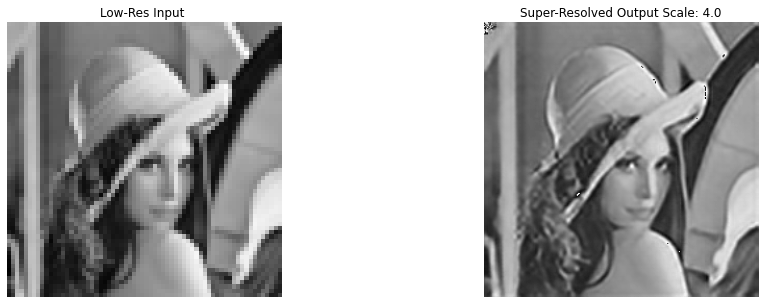

In [36]:
prediction = model(input,v)

fig = plt.figure(figsize=(20, 40))
subplot = fig.add_subplot(10, 3, 1)
subplot.imshow(transforms.ToPILImage()(input[0].cpu()),cmap="gray")
subplot.title.set_text('Low-Res Input ')
subplot.axis('off')

subplot = fig.add_subplot(10, 3, 2)
subplot.imshow(transforms.ToPILImage()(prediction[0].cpu()),cmap="gray")
subplot.title.set_text('Super-Resolved Output ' + 'Scale: ' + str(UPSCALE_FACTOR))
subplot.axis('off')
plt.tight_layout() 
plt.show()

It's the famous Lenna! Notice how pixelated the original image is, and how much clearer and recognisable she is on the right.

Note: The image was taken from Wikipedia and no copyright infringement is intended. This is purely for educational purposes.

**Medical Image Analysis**

MRI scans are often low-resolution because the patient moves about and interferes with the MRI scans. Most MRI scans are also very small, making it hard to use in any sort of cross-modality analysis. For example, most CT scans and ultrasounds are 512 x 512 whereas MRI scans are 128 x 128. This makes it hard to do cross-modality analysis as they are of different scales of resolution.

Super-Resolution can help by increasing the resolution of MRI scans without compromising fidelity.

Let's take a look at an MRI scan. This is from the BraTS dataset, an open-source dataset of brain MRI images.

(-0.5, 127.5, 127.5, -0.5)

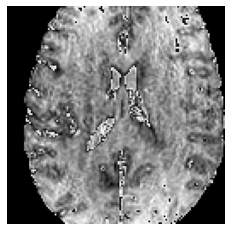

In [0]:
img = Image.open('brats_example.png').convert('YCbCr')
plt.imshow(img,cmap="gray")
plt.axis("off")

Okay. It looks fine, but really we want to make it larger in order for it to have any use in cross-modality analysis.

Again, we load the image in as a PyTorch tensor.

In [0]:
img = Image.open('brats_example.png').convert('YCbCr')
h , w = img.size
img = test_transform(min(h,w))(img)
y, _,_ = img.split()
input = y
input = transforms.ToTensor()(input)
input = torch.stack([input]).to(device)
N,C,H,W = input.shape

print(input)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


And load Meta-SRGAN. Note that we are using a different version of Meta-SRGAN. This one is trained on the BraTS dataset.

In [0]:
UPSCALE_FACTOR = 2
model = Generator(in_channels=1,out_channels=1,scale_factor=UPSCALE_FACTOR).to(device)
model.load_state_dict(torch.load('metasrgan_tutorial_brats.pth',map_location='cuda:0'))
v = create_v(H,W,UPSCALE_FACTOR).to(device)

We run the medical image through Meta-SRGAN, and show the result.

We clip the output's pixel values to between 0 and 255 because colour is represented by 8 bits (i.e. ranging from values 0 to 255).

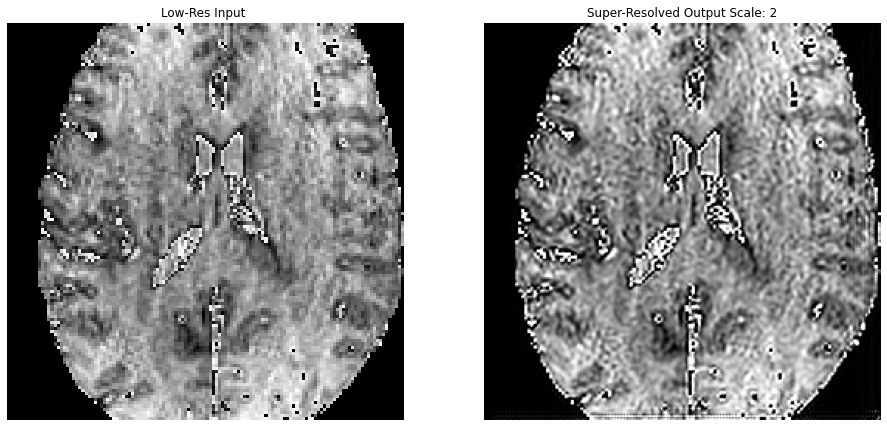

In [0]:
prediction = model(input,v)
prediction = prediction.mul(255).clamp(0, 255).round().div(255)

fig = plt.figure(figsize=(20, 40))
subplot = fig.add_subplot(7, 3, 1)
subplot.imshow(transforms.ToPILImage()(input[0].cpu()),cmap="gray")
subplot.title.set_text('Low-Res Input ')
subplot.axis('off')

subplot = fig.add_subplot(7, 3, 2)
subplot.imshow(transforms.ToPILImage()(prediction[0].cpu()),cmap="gray")
subplot.title.set_text('Super-Resolved Output ' + 'Scale: ' + str(UPSCALE_FACTOR))
subplot.axis('off')
plt.tight_layout() 
plt.show()

The super-resolved image definitely enhances the details of the MRI scan. Whereas the low-resolution input appears somewhat chunky and pixelated, the super-resolved image looks more detailed. 

**Text Enhancement**

Text enhancement using Super-Resolution can be useful for the visually impaired, as low-resolution blurry text can be transformed into more recognisable text, significantly reducing strain on the eyes. 

Let's load an image of some text and see if we recognise the words.

(-0.5, 206.5, 57.5, -0.5)

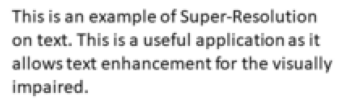

In [0]:
img = Image.open('text_example.png').convert('YCbCr')
plt.imshow(img,cmap="gray")
plt.axis("off")

Whilst it may be readable to us, it is still blurry, and may not be readable to the visually impaired. It is also quite straining to read the text.

Let's run it through Meta-SRGAN.

In [0]:
img = Image.open('text_example.png').convert('YCbCr')
h , w = img.size
y, _,_ = img.split()
input = y
input = transforms.ToTensor()(input)
input = torch.stack([input]).to(device)
N,C,H,W = input.shape

print(input)

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9529,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]],
       device='cuda:0')


Load Meta-SRGAN.

In [0]:
UPSCALE_FACTOR = 4
model = Generator(in_channels=1,out_channels=1,scale_factor=UPSCALE_FACTOR).to(device)
model.load_state_dict(torch.load('metasrgan_tutorial.pth',map_location='cuda:0'))
v = create_v(H,W,UPSCALE_FACTOR).to(device)

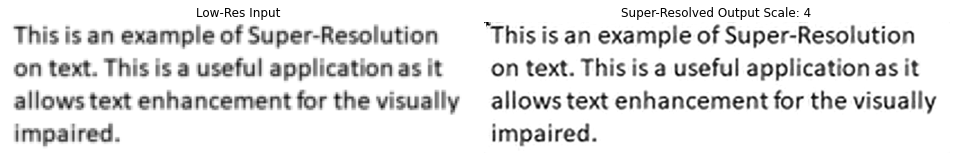

In [0]:
prediction = model(input,v)
prediction = prediction.mul(255).clamp(0, 255).round().div(255)

fig = plt.figure(figsize=(20, 40))
subplot = fig.add_subplot(10, 3, 1)
subplot.imshow(transforms.ToPILImage()(input[0].cpu()),cmap="gray")
subplot.title.set_text('Low-Res Input ')
subplot.axis('off')

subplot = fig.add_subplot(10, 3, 2)
subplot.imshow(transforms.ToPILImage()(prediction[0].cpu()),cmap="gray")
subplot.title.set_text('Super-Resolved Output ' + 'Scale: ' + str(UPSCALE_FACTOR))
subplot.axis('off')
plt.tight_layout() 
plt.show()

The super-resolved image is certainly less blurry.

I hope this short tutorial has illustrated the uses of Super-Resolution, and of Meta-SRGAN. It's lightweight, generates images of high visual quality, and can tackle arbitrary scales. Notice how we can easily switch between upscaling factors 2 and 4. Feel free to play around with the upscaling factors or use your own low-resolution images.